# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import seaborn as sn
import plotnine as pln
import anndata
import scanpy as sc
import scvelo as scv
import sctk as sk
import cellrank as cr
import scirpy as ir

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)
sc.settings.verbosity = 0

# Load data

In [2]:
tnk_ad = sc.read('../20210324_vdj/fetal_skin.lymphoid_T_NK.doublet_removed_processed.20200403.TCR.h5ad')

In [20]:
tnk_ad

AnnData object with n_obs × n_vars = 17943 × 20535
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'rachel_annot1', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'leiden_hm_r0_4_split', 'rachel_annot2', 'leiden_hm_split1', 'rachel_annot3', 'multi_chain', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', '

In [166]:
full_ad = sc.read('fetal_skin.processed_with_norm_X_counts_layer.maternal_removed.20211029.h5ad', backed='r')

In [168]:
full_ad

AnnData object with n_obs × n_vars = 186582 × 28885 backed at 'fetal_skin.processed_with_norm_X_counts_layer.maternal_removed.20211029.h5ad'
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells', 'cc'
    uns: 'neighbors', 'neighbors_bk', 'pca'
    obsm: 'X_pca', 'X_umap', 'X_umap_bk'
    layers: 'counts'

In [167]:
full_ad.obs_names[0:4]

Index(['AAACCTGGTCAGTGGA-1-4834STDY7002879',
       'AAAGATGGTCGATTGT-1-4834STDY7002879',
       'AAAGCAAAGATGTGGC-1-4834STDY7002879',
       'AAAGTAGCAGATCGGA-1-4834STDY7002879'],
      dtype='object', name='index')

In [140]:
pan_obs = pd.read_csv('PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv.gz', index_col=0)

In [142]:
pan_obs.head()

,n_counts,n_genes,file,mito,doublet_scores,predicted_doublets,name,uniform_label,uniform_label_expanded_merged,uniform_label_lvl0,...,Sample.lanes,Sort_id,age,method,donor,sex,Processing_method,AnnatomicalPart,Sample,anno_lvl_2_final_clean
FCAImmP7579224-ATTACTCTCGATGAGG,61563.0,6117,FCAImmP7579224,0.036321,0.087221,False,FCAImmP7579224_filtered.h5ad,NaN,NaN,NaN,...,FCAImmP7579224,CD45P,12,5GEX,F45,female,Collagnase,Random,F45_SK_CD45P_FCAImmP7579224,CYCLING_DC
FCAImmP7579224-CAGCCGAGTACATCCA,61511.0,6658,FCAImmP7579224,0.051909,0.125320,False,FCAImmP7579224_filtered.h5ad,NaN,NaN,NaN,...,FCAImmP7579224,CD45P,12,5GEX,F45,female,Collagnase,Random,F45_SK_CD45P_FCAImmP7579224,EARLY_ERY
FCAImmP7579224-TGCTACCTCATGTAGC,54545.0,6485,FCAImmP7579224,0.045284,0.164087,False,FCAImmP7579224_filtered.h5ad,NaN,NaN,NaN,...,FCAImmP7579224,CD45P,12,5GEX,F45,female,Collagnase,Random,F45_SK_CD45P_FCAImmP7579224,PRE_DC2
FCAImmP7579224-ACGGCCACAAGCTGAG,51992.0,5768,FCAImmP7579224,0.040083,0.092437,False,FCAImmP7579224_filtered.h5ad,NaN,NaN,NaN,...,FCAImmP7579224,CD45P,12,5GEX,F45,female,Collagnase,Random,F45_SK_CD45P_FCAImmP7579224,MONOCYTE_II_CCR2
FCAImmP7579224-CTAATGGCACTGTGTA,51305.0,5492,FCAImmP7579224,0.046467,0.176471,False,FCAImmP7579224_filtered.h5ad,NaN,NaN,NaN,...,FCAImmP7579224,CD45P,12,5GEX,F45,female,Collagnase,Random,F45_SK_CD45P_FCAImmP7579224,LARGE_PRE_B


In [150]:
pan_obs.index = (pd.Series(pan_obs.index).str.rpartition('-')[2] + '-1-' + pd.Series(pan_obs.index).str.rpartition('-')[0]).values

In [67]:
def read_gdTCR(vdj_id, gex_id):
    input_tsv = f'../data/vdj/gdTCR/{vdj_id}.hiconf_contig_igblast_db-pass.tsv'
    gdtcr_df = pd.read_csv(input_tsv, sep='\t', index_col=0)
    out_tsv = gdtcr_df.groupby('cell_id').agg(
        gd_v_call=pd.NamedAgg(column='v_call', aggfunc=lambda x: '/'.join(x.unique().astype(str))),
        gd_d_call=pd.NamedAgg(column='d_call', aggfunc=lambda x: '/'.join(x.unique().astype(str))),
        gd_j_call=pd.NamedAgg(column='j_call', aggfunc=lambda x: '/'.join(x.unique().astype(str))),
        gd_c_call=pd.NamedAgg(column='c_call', aggfunc=lambda x: '/'.join(x.unique().astype(str))),
        gd_n_productive=pd.NamedAgg(column='productive', aggfunc=lambda x: (x=='T').sum())
    )
    out_tsv.index = pd.Series(out_tsv.index).astype(str) + f'-{gex_id}'
    return out_tsv

In [57]:
gdtcr_inputs = pd.read_csv('gdTCR_metadata_02082021.csv', index_col=0)

In [58]:
gdtcr_inputs.head()

,GDTCR,GDTCR_sample,GEX file,GDTCR_mapping,sample
0,WSSS_F_Imm10424040,F41_LI_45P_GDTCR,FCAImmP7555856,/archive/HCA/10X-VDJ/$SAMPLE/dandelion/dandeli...,F41_LI_45P_5GEX
1,WSSS_F_Imm10424041,F41_SK_45P_GDTCR,FCAImmP7555858,NaN,F41_SK_45P_5GEX
2,WSSS_F_Imm10424042,F41_TH_45P_GDTCR,FCAImmP7555860,NaN,F41_TH_45P_5GEX
3,WSSS_F_Imm10424043,F41_BM_45P_GDTCR,FCAImmP7555862,NaN,F41_BM_45P_5GEX
4,WSSS_F_Imm10424044,F45_LI_45P_GDTCR,FCAImmP7579226,NaN,F45_LI_45P_5GEX


In [72]:
gdtcr_dfs = [read_gdTCR(row.GDTCR, row['GEX file']) for i, row in gdtcr_inputs.loc[gdtcr_inputs.GDTCR_sample.str.contains('_SK_'), ['GDTCR', 'GEX file']].iterrows()]    

In [74]:
gdtcr_df = pd.concat(gdtcr_dfs)

In [83]:
gdtcr_df.head()

,gd_v_call,gd_d_call,gd_j_call,gd_c_call,gd_n_productive
cell_id,,,,,
AAACGGGAGTACGCCC-1-FCAImmP7555858,TRDV2*01,TRDD3*01,TRDJ2*01,TRDC,0
AACGTTGTCATCGCTC-1-FCAImmP7555858,TRAV36/DV7*01,TRDD2*01,TRDJ2*01,TRDC,1
AACTGGTAGTAGGTGC-1-FCAImmP7555858,TRGV9*01/TRDV2*03,nan/TRDD3*01,TRGJP*01/TRDJ1*01,TRGC1/TRDC,2
ACCCACTAGTGTCCCG-1-FCAImmP7555858,TRGV9*01/TRDV2*03,nan/TRDD3*01,TRGJP*01/TRDJ1*01,TRGC1/TRDC,2
ACCTTTATCAACCAAC-1-FCAImmP7555858,TRDV2*03,TRDD3*01,TRDJ1*01,TRDC,1


# Process

In [ ]:
tnk_ad.obs_names.isin(gdtcr_df.index).sum()

650

In [79]:
np.all(tnk_ad.obs.merge(gdtcr_df, how='left', left_index=True, right_index=True).index == tnk_ad.obs_names)

True

In [81]:
tnk_ad.obs = tnk_ad.obs.merge(gdtcr_df, how='left', left_index=True, right_index=True)
tnk_ad.obs['has_gdir'] = (tnk_ad.obs['gd_n_productive'] > 0)
tnk_ad.obs['has_gdir'] = tnk_ad.obs['has_gdir'].astype('category')
tnk_ad.obs.loc[tnk_ad.obs.gd_n_productive.astype(str)=='nan', 'has_gdir'] = np.nan
tnk_ad.obs['has_gdir'] = tnk_ad.obs['has_gdir'].astype('category')
tnk_ad.obs['gd_n_productive'] = tnk_ad.obs['gd_n_productive'].astype('category')

In [108]:
gdTCR_samples = pd.Series(gdtcr_df.index).str.rpartition('-')[2].unique()

In [154]:
tnk_ad.obs = tnk_ad.obs.merge(pan_obs[['anno_lvl_2_final_clean']], how='left', left_index=True, right_index=True)
tnk_ad.obs['anno_lvl_2_final_clean'] = tnk_ad.obs['anno_lvl_2_final_clean'].astype(str).astype('category')

In [171]:
tnk_ad.obs = tnk_ad.obs.merge(full_ad.obs[['independent_annotation_refined', 'joint_annotation', 'fig1b_annotation']], how='left', left_index=True, right_index=True)

In [174]:
for col_name in ['independent_annotation_refined', 'joint_annotation', 'fig1b_annotation']:
    tnk_ad.obs[col_name].cat.remove_unused_categories(inplace=True)

# Plot

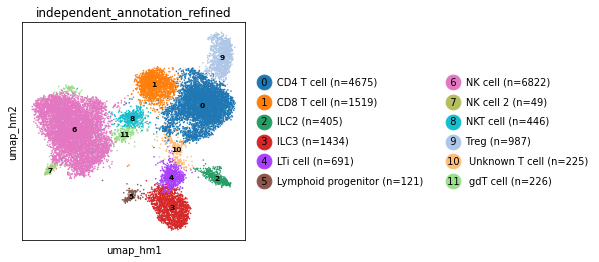

In [175]:
sk.plot_embedding(tnk_ad, basis='umap_hm', groupby='independent_annotation_refined', add_outline=False, size=10, annot='full');

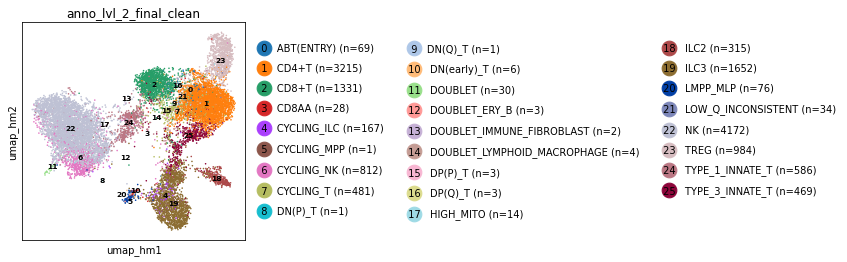

In [192]:
sk.plot_embedding(tnk_ad[tnk_ad.obs.anno_lvl_2_final_clean!='nan'].copy(), basis='umap_hm', groupby='anno_lvl_2_final_clean', add_outline=False, size=10, annot='full');

In [187]:
sk.cross_table(tnk_ad, 'anno_lvl_2_final_clean', 'independent_annotation_refined')

independent_annotation_refined,CD4 T cell,CD8 T cell,ILC2,ILC3,LTi cell,Lymphoid progenitor,NK cell,NK cell 2,NKT cell,Treg,Unknown T cell,gdT cell
anno_lvl_2_final_clean,,,,,,,,,,,,
ABT(ENTRY),48,21,0,0,0,0,0,0,0,0,0,0
CD4+T,3133,29,3,0,2,1,1,0,0,44,2,0
CD8+T,63,1236,0,0,1,0,1,0,18,1,9,2
CD8AA,8,1,1,3,0,9,0,0,5,1,0,0
CYCLING_ILC,1,0,0,128,33,1,3,0,0,0,1,0
CYCLING_MPP,0,0,0,0,0,1,0,0,0,0,0,0
CYCLING_NK,4,1,1,5,11,4,759,0,17,1,3,6
CYCLING_T,332,78,8,1,9,0,4,0,12,6,30,1
DN(P)_T,0,0,0,0,0,1,0,0,0,0,0,0


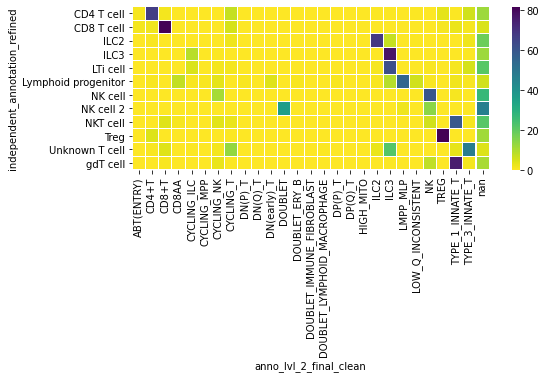

In [190]:
sk.cross_table(tnk_ad, 'independent_annotation_refined', 'anno_lvl_2_final_clean', normalise='x', plot=True, figsize=(8, 3));

In [122]:
tnk_ad0 = tnk_ad[tnk_ad.obs.sanger_id.isin(gdTCR_samples)].copy()

In [123]:
tnk_ad1 = tnk_ad0[tnk_ad0.obs.has_gdir == 1].copy()

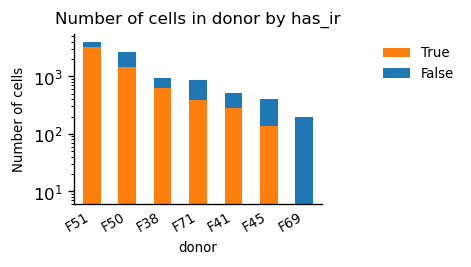

In [30]:
ir.pl.group_abundance(tnk_ad0, groupby='donor', target_col='has_ir', log=True);

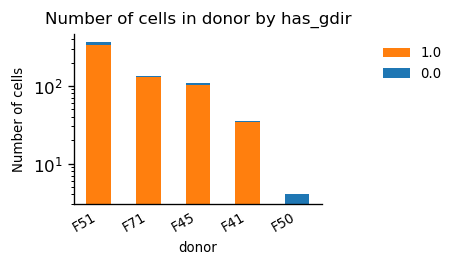

In [117]:
ir.pl.group_abundance(tnk_ad0, groupby='donor', target_col='has_gdir', log=True);

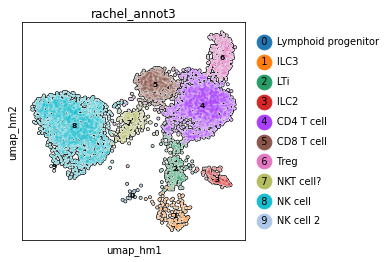

In [119]:
sk.plot_embedding(tnk_ad0, basis='umap_hm', groupby='rachel_annot3', add_outline=True, alpha=0.3, size=20);

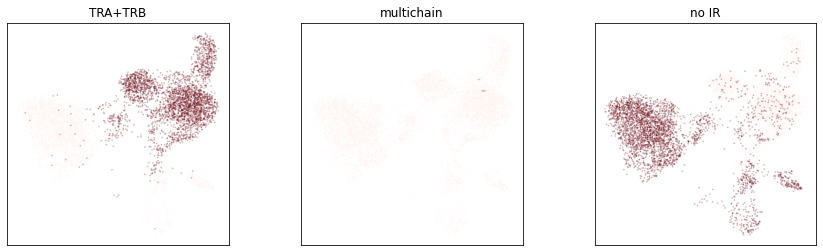

In [136]:
sk.set_figsize((4, 4))
sk.highlight(tnk_ad0, basis='umap_hm', groupby='receptor_subtype', add_outline=False, alpha=0.3, size=10)

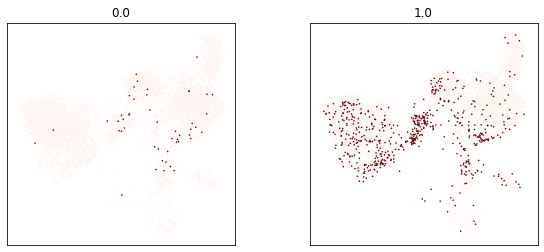

In [137]:
sk.set_figsize((4, 4))
sk.highlight(tnk_ad0, basis='umap_hm', groupby='has_gdir', add_outline=False, size=10)

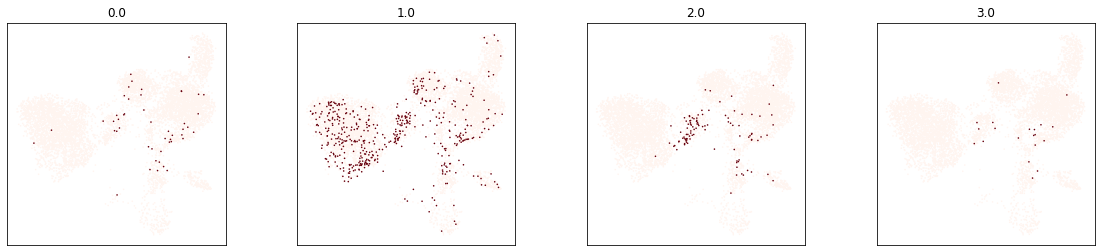

In [135]:
sk.set_figsize((4, 4))
sk.highlight(tnk_ad0, basis='umap_hm', groupby='gd_n_productive', add_outline=False, size=10)

In [131]:
tnk_ad0.obs.loc[tnk_ad0.obs.gd_n_productive==2, 'gd_v_call'].value_counts()

TRDV2*03/TRGV9*01         23
TRGV9*01/TRDV2*03         20
TRAV36/DV7*01/TRDV2*03     3
TRGV8*01/TRDV2*03          3
TRDV2*03/TRGV10*02         3
                          ..
TRGV2*01                   0
TRGV2*02                   0
TRGV3*01                   0
TRGV3*01/TRDV2*03          0
TRAV3*01                   0
Name: gd_v_call, Length: 119, dtype: int64

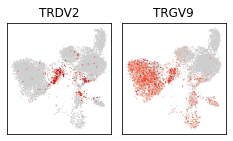

In [132]:
sk.set_figsize((4, 4))
sk.plot_genes(tnk_ad0, basis='umap_hm', genes=['TRDV2', 'TRGV9'], size=5)

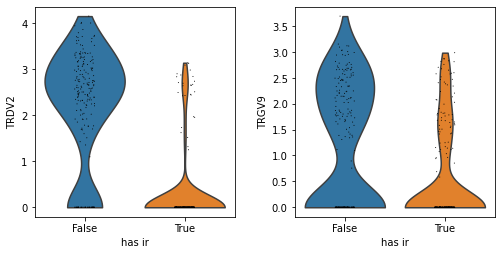

In [118]:
sk.set_figsize((4, 4))
sk.pl.violin(tnk_ad0[tnk_ad0.obs.rachel_annot3=='NKT cell?'], ['TRDV2', 'TRGV9'], groupby='has_ir')

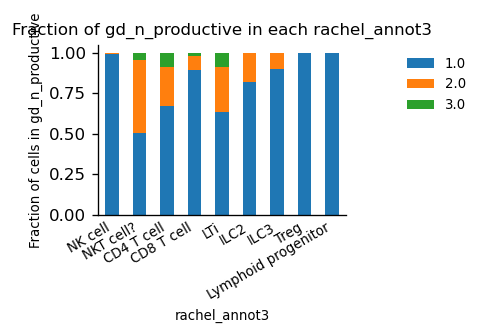

In [133]:
sk.set_figsize((2, 4))
ir.pl.group_abundance(tnk_ad1, groupby='rachel_annot3', target_col='gd_n_productive', normalize=True);

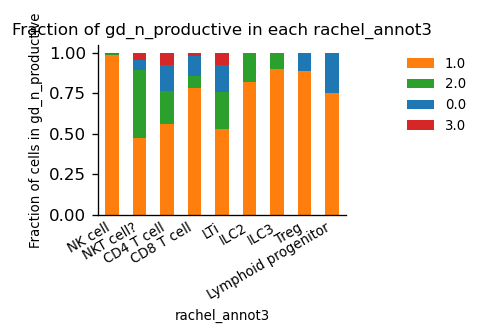

In [139]:
sk.set_figsize((2, 4))
ir.pl.group_abundance(tnk_ad0, groupby='rachel_annot3', target_col='gd_n_productive', normalize=True);

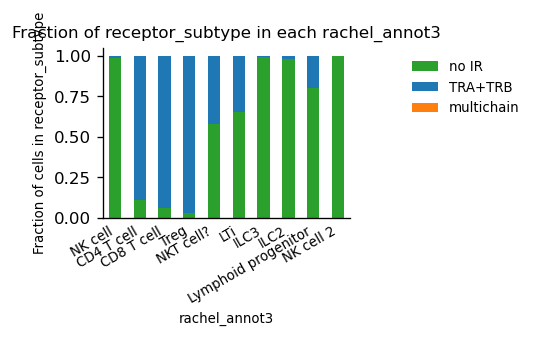

In [128]:
sk.set_figsize((2, 4))
ir.pl.group_abundance(tnk_ad0, groupby='rachel_annot3', target_col='receptor_subtype', normalize=True);

In [129]:
tnk_ad.write('fetal_skin.lymphoid_T_NK.doublet_removed_processed.20200403.TCR_gdTCR.h5ad', compression='lzf')